# Lab 4 bis: **Invariance** in a *shallow FCN* under data augmentation

Advanced Topics in Machine Learning -- Spring 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_UniTS_2023_Lab_04bis_FCN_Invariance.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

#### High-level overview

In this *Lab*, we will understand how the effect of *data augmentation* (whose effect on learned **weights** has been analyzed in the previous lab) translates to the **representation** learned by the model.

Specifically, we define *representation* the (ordered) set of activations of a *neural network* model, which is dependent on the input, and can be seen as the way the model *sees* the data as a result of the learning process.

To accomplish this goal, we will:

- Load the weights resulting from the training of the model described in the previous lab;
- Learn how to extract the activations of a given layer of the model, in response to a given input;
- Evaluate such activations on mutually-rotated versions of the same input, and compare such activations to assess their *invariance*  with respect to the transformation.

#### Preliminary: adapt and re-run the previous notebook

Before starting to delve into this lab, you should:
- Go back to the previous *Lab* notebook;
- Add the (single line of) code required to save the model weights after training;
- Re-run the notebook, to make sure that the weights are saved correctly;


#### (Re-)definition of the model

Define the exact same model you used in the previous lab, and instantiate it.

In [1]:
from tqdm import trange

import numpy as np

import torch 
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt

In [2]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 2
LEARNING_RATE = 0.01
MOMENTUM = 0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Defining transforms
augmentation = transforms.RandomAffine(degrees=(0, 180), translate=None, scale=None)
to_tensor = transforms.ToTensor()
normalization = transforms.Normalize(mean=0.1307, std=0.3081)

# Loading the datasets
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transforms.Compose([augmentation, to_tensor, normalization]),
    download=True,
)
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transforms.Compose([augmentation, to_tensor, normalization]),
    download=True,
)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


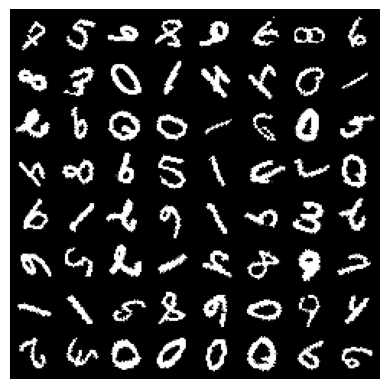

In [4]:
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = train_loader.__iter__()
images, labels = dataiter.__next__()

# show images
imshow(torchvision.utils.make_grid(images))

In [5]:
# Model definition
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)  # More numerically stable than softmax
        return x

In [6]:
model = MyModel()
model.to(device)

MyModel(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

In [7]:
num_epochs = 5  # Number of times the whole (training) dataset is used for training
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
def get_batch_accuracy(logit, target):
    """Obtain accuracy for one batch of data"""
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()

In [9]:
train_loss = []
for epoch in trange(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model1 = (
        model.train()
    )  # Set the model to training mode: relevant for dropout, batchnorm, etc.

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass + (automated) BackProp + Loss computation
        logits = model1(images)
        loss = criterion(logits, labels)

        optimizer.zero_grad()  # Reset the gradients to zero: otherwise they accumulate!
        loss.backward()  # Backpropagation

        # Update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_batch_accuracy(logits, labels)

    model.eval()
    print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i} | Train Accuracy: {train_acc/i}")
    train_loss.append(train_running_loss)

# Save the model
torch.save(model.state_dict(), "model.pth")

  0%|          | 0/5 [00:15<?, ?it/s]


KeyboardInterrupt: 

#### Weights loading

Load into the instance of your model the weights you just saved from the adapted notebook.

In [10]:
#load the model
model = MyModel()
model.to(device)
model.load_state_dict(torch.load("model.pth"))
model.eval()


MyModel(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

#### Data preparation

To test for a given transformation invariance, you should have pairs of (test) data obtained from the same image: one original, and one transformed.

**Hint**: if you want to offload the task to already implemented `torchvision.transforms`, notice (to your advantage) that -- since we are just testing the model -- the dataset needs not to be in shuffled order!


In [11]:
# Hyperparameters
BATCH_SIZE = 1024

In [12]:

# Defining transforms
augmentation = transforms.RandomAffine(degrees=(0, 180), translate=None, scale=None)
to_tensor = transforms.ToTensor()
normalization = transforms.Normalize(mean=0.1307, std=0.3081)

# Defining testing data-sets/loaders
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    # Original: no augmentation
    transform=transforms.Compose([to_tensor, normalization]),
    download=True,
)
test_dataset_rot = datasets.MNIST(
    root="./data",
    train=False,
    # Transformed: augmented
    transform=transforms.Compose([augmentation, to_tensor, normalization]),
    download=True,
)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader_rot = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### Activation extraction

Write a function that extracts the activations of a given layer of the model, in response to a given input. Try to remain as generic as possible, since you may need to re-use it in the future.

**Hint**: Look up in the documentation the purpose and features of `hook`s. If you are in trouble, just ask!


In [13]:
from typing import Dict, Iterable, Callable
from torch import Tensor

class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: Iterable[str]):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id] # named modules provide each layer with its name, so we can access it by name
            layer.register_forward_hook(self.save_activation_hook(layer_id))

    def save_activation_hook(self, layer_id: str) -> Callable:
        def fn(_, __, input):
            self._features[layer_id] = input
        return fn

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        _ = self.model(x)
        return self._features

In [14]:
featex = FeatureExtractor(model, ["fc"])
out = model(images)


In [15]:
featex(images)

{'fc': tensor([[-7.5738e+00,  1.1617e+00,  4.3666e-01,  3.3289e+00,  4.1764e-02,
           2.0687e-01, -3.9713e+00, -1.9156e+00,  2.4799e+00,  1.5643e+00],
         [-5.7795e+00, -1.0244e+01, -8.5110e-01, -7.2056e+00,  4.9509e+00,
          -3.2571e+00, -9.0962e-01,  5.4646e+00,  1.0571e-01,  6.8719e+00],
         [-4.3954e+00, -9.3266e-01, -8.4303e-02,  1.1720e+00,  2.6591e-01,
           1.3240e+00, -2.9008e+00,  1.6945e+00,  5.8341e-01,  2.2973e+00],
         [ 1.2922e-01, -5.1848e+00,  1.0548e+00, -2.0356e+00,  3.8212e+00,
           1.5259e+00,  2.5821e+00,  6.5432e-01,  1.7407e-01,  1.2438e+00],
         [-1.4019e+00, -4.0623e+00,  5.2542e+00,  7.6848e-01,  1.7356e+00,
           1.1317e+00,  1.2598e+00, -3.0782e+00,  1.7285e+00, -6.0617e+00],
         [ 8.1255e+00, -1.5190e+01,  2.5693e+00,  2.3098e+00, -4.3170e+00,
           3.7858e+00, -1.7473e+00, -1.3395e+00,  1.1204e+00, -5.9733e+00],
         [ 6.5128e+00, -2.4367e+01,  3.7113e+00, -2.6334e+00,  7.2444e-01,
           8.

#### Invariance evaluation

Recall the definition of *invariance* of (the result of) function $f$ with respect to transformation $g(\cdot\;; \alpha)$ parametrized by $\alpha$:

$$f(g(x; \alpha))=f(x)\;\;\;\; \forall\alpha$$

With the function and data just defined, compare in a statistically-significant manner the activations of the model on the original and transformed versions of the same image. Comment on the results.


In [16]:
test_iter = test_loader.__iter__()
images, labels = test_iter.__next__()
test_iter_r = test_loader_rot.__iter__()
images_r, labels_r = test_iter_r.__next__()


In [17]:
act = featex(images.to(device))
act_r = featex(images_r.to(device))

In [21]:
act['fc'].shape


torch.Size([1024, 10])

In [22]:
act_fc = act['fc'].reshape(act['fc'].shape[0], -1, 28, 28)
imshow(torchvision.utils.make_grid(act_fc.detach().cpu()))

RuntimeError: shape '[1024, -1, 28, 28]' is invalid for input of size 10240

: 